# Deep Neural Network for Synthetic Time Series Dataset

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [2]:
def plot_series(time,series, format = '-', start =0, end = None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Series")
  plt.grid(True)

In [16]:
def trend(time, slope=0):
  return time*slope

def seasonal_pattern(season_time):
  return np.where(season_time<0.4,
                  np.cos(season_time * 2*np.pi),
                  1/np.exp(3*season_time))
  
def seasonality(time, period, amplitude=1, phase = 0):
  season_time = ((time+phase)%period)/period
  return amplitude*seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time))*noise_level

In [21]:
time = np.arange(4*365+1,dtype='float32')
# baseline = 10
# series = trend(time, slope=0.1)
amplitude = 20
slope = 0.09
noise_level = 5

## Creating synthetic Time series

In [22]:
series = baseline+ trend(time,slope) + seasonality(time, period=365, amplitude=amplitude)
series+=noise(time, noise_level, seed = 42)

In [23]:
split_time = 1000
train_series = series[:split_time]
train_time = time[:split_time]

valid_series = series[split_time:]
valid_time = time[split_time:]

### Visualizing the validation data

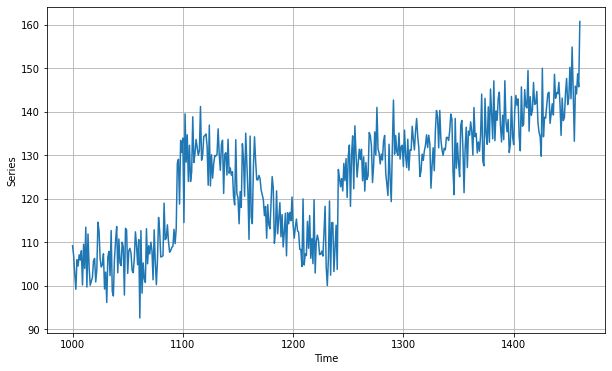

In [24]:
plt.figure(figsize=(10,6))
plot_series(valid_time, valid_series)

In [25]:
window_size = 20
batch_size = 32
shuffle_batch_size = 1000

## Preparing the dataset

In [26]:
def windowed_dataset(series, window_size, batch_size, shuffle_batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_batch_size).map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## Building Neural Network: 3 layers

In [28]:
dataset = windowed_dataset(train_series, window_size, batch_size, shuffle_batch_size)

model = tf.keras.models.Sequential([
     tf.keras.layers.Dense(10, input_shape = [window_size], activation='relu'),
     tf.keras.layers.Dense(10, activation='relu'),
     tf.keras.layers.Dense(1)
])

model.compile(loss = 'mse', optimizer = tf.keras.optimizers.SGD(lr = 1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose = 0)


### Forecasting

In [29]:
forecast = []
for time in range(len(series)-window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0 ,0]

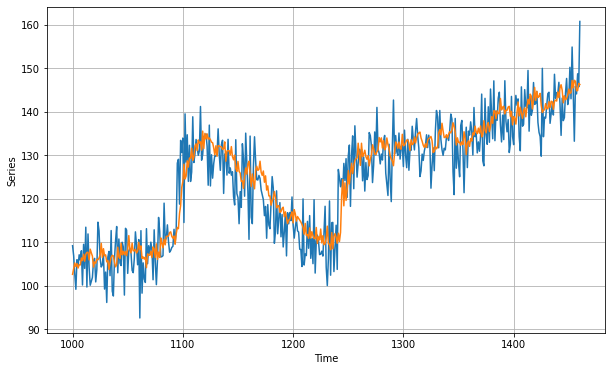

In [30]:
plt.figure(figsize=(10,6))
plot_series(valid_time, valid_series)
plot_series(valid_time, results)


Mean absolute error between forecasting results and validation data

In [32]:
tf.keras.metrics.mean_absolute_error(valid_series, results).numpy()

4.6107926

## Learning Rate Scheduler Callback

In [33]:
dataset = windowed_dataset(series, window_size, batch_size, shuffle_batch_size)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(10, activation='relu', input_shape = [window_size]),
                                    tf.keras.layers.Dense(10, activation='relu'),
                                    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)


model.compile(loss= 'mse', optimizer=tf.keras.optimizers.SGD(1e-8, momentum=0.9))
history = model.fit(dataset, epochs= 100, callbacks=[lr_schedule], verbose=0)

### Plotting the loss throughout changing learning rate

(1e-08, 0.001, 0.0, 300.0)

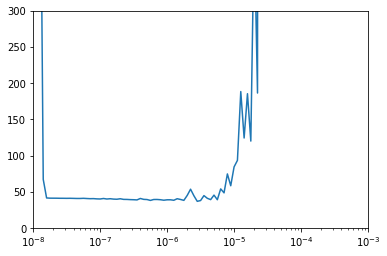

In [34]:
lrs = 1e-8 * (10**(np.arange(100)/20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0 , 300])

### Picking the most stable and minimum loss producing learning rate

In [42]:
window_size = 30
dataset = windowed_dataset(series, window_size, batch_size, shuffle_batch_size)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(10, activation='relu', input_shape = [window_size]),
                                    tf.keras.layers.Dense(10, activation='relu'),
                                    tf.keras.layers.Dense(1)
])

model.compile(loss= 'mse', optimizer=tf.keras.optimizers.SGD(3e-6, momentum=0.9))  ## We picked 3e-6 from the graph
history = model.fit(dataset, epochs= 500, verbose=0)

### plotting the graph of the loss after the training:
This plot has an L shape, which means that there is a drastic decrease of loss after only few epochs. So, to truely analyze the nature of loss for all the epochs after such drastic decrease, we have to eliminate these first few epochs from the visualization to reduce the range of axis and get a more magnified look on rest of the loss achieved in later epochs.

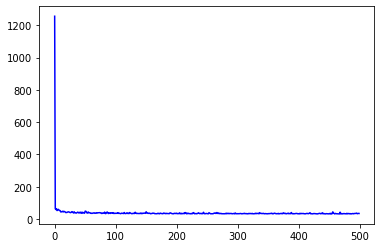

In [43]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label="training_loss")
plt.show()

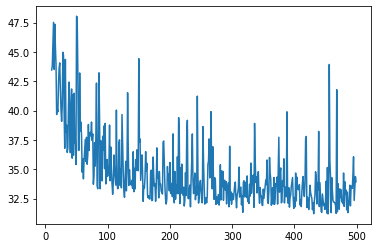

In [44]:
plt.plot(epochs[10:], loss[10:])

### Forecasting

In [45]:
forecast = []

for time in range(len(series)-window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[: , 0,0]

### Visualization of the Forecast and Validation set

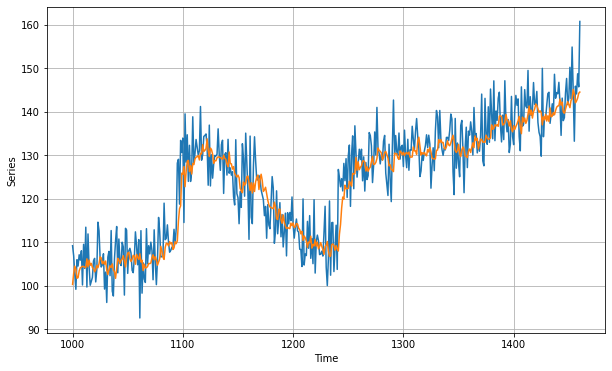

In [46]:
plt.figure(figsize=(10,6))
plot_series(valid_time, valid_series)
plot_series(valid_time, results)

Mean absolute error between forecast and validation data

In [47]:
tf.keras.metrics.mean_absolute_error(valid_series, results).numpy()

4.4020343